### Задача: предсказать отток пользователя сервиса (задача классификации)
### Важность метрик: recall > precision, т.к. нам нужно охватить максимально возможное кол-во уходящих пользователей
### Используется ROC AUC, т.к. дисбаланс классов небольшой (74/26)

### Импорты

In [329]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

### Загрузка данных

In [330]:
df = pd.read_csv('TelcoCustomerChurn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Предобработка данных

Разделение на фичи и таргет

In [331]:
df = df.drop(columns = 'customerID')
X = df.drop('Churn', axis = 1)
y = df['Churn']

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Проверка на пустые значения

In [332]:
df.isna().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

Проверка на дизбаланс классов

In [333]:
y.value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Разделение данных на вещественные и категориальные фичи

In [334]:
num_cols = X.select_dtypes(include = 'number').columns
cat_cols = X.select_dtypes(include = 'object').columns.to_list()

### Работа с вещественными признаками

Матрица корреляций

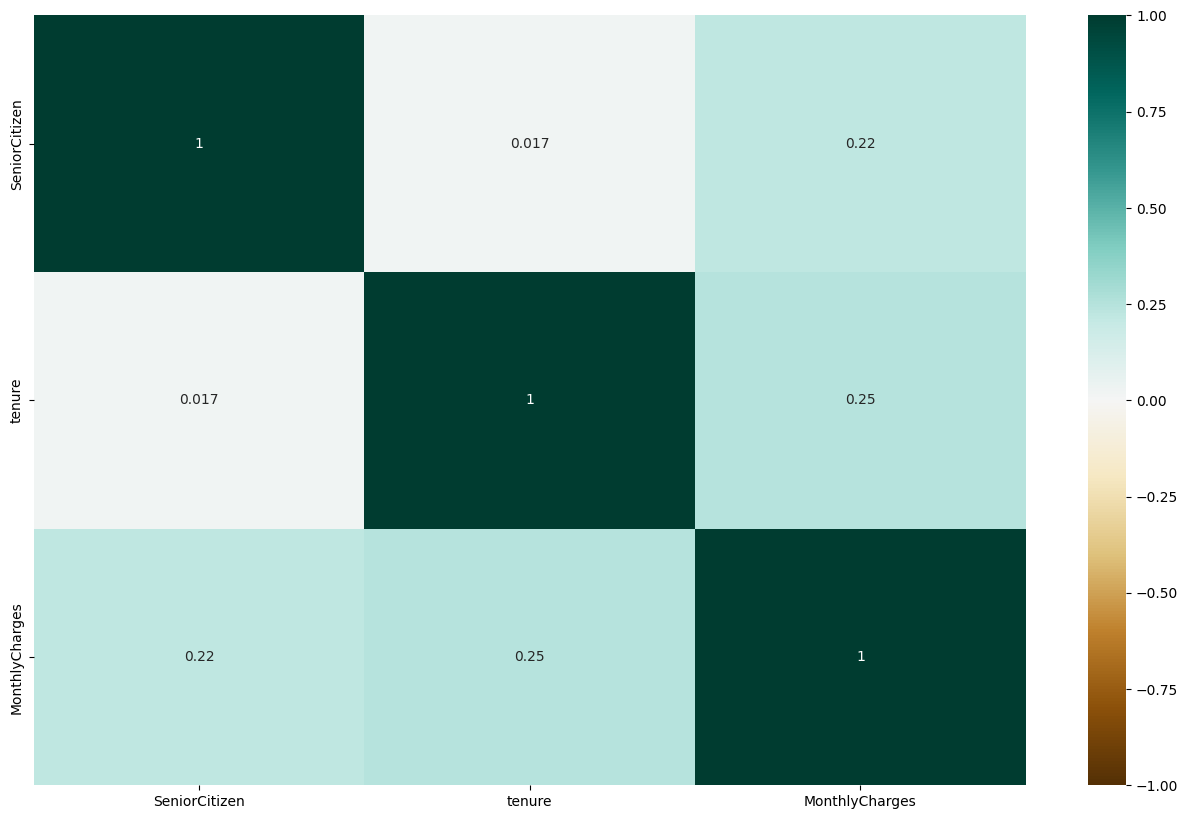

In [335]:
fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[num_cols].corr(),
            xticklabels=num_cols,
            yticklabels=num_cols,
            cmap='BrBG',
            annot=True,
            vmin=-1,
            vmax=1)

plt.show()

По этой матирце мы видим что фичи **tenure(сколько месяцев клиент уже с компанией)** и **TotalCharges(общая сумма, уплаченная клиентом)** имеют корреляцию 0.83. Это мультиколлениарность, т.е. они несут почти одну и ту же информацию. Из-за этого модель становиться более чуствительна к шуму. Нужно удалить одну из этих фичей. Я удалю TotalCharges т.к. у него ещё есть подозрительно большая, но терпимая корреляция с **MonthlyCharges(ежемесячные платежи)**(0.65).

In [336]:
X = X.drop(columns = 'TotalCharges')
num_cols = X.select_dtypes(include = 'number').columns
cat_cols = X.select_dtypes(include = 'object').columns.to_list()

### Работа с категориальными признаками

Гистограммы распределения признаков (дроп признаков, распределение которых, примерно одинаково на обоих категориях)

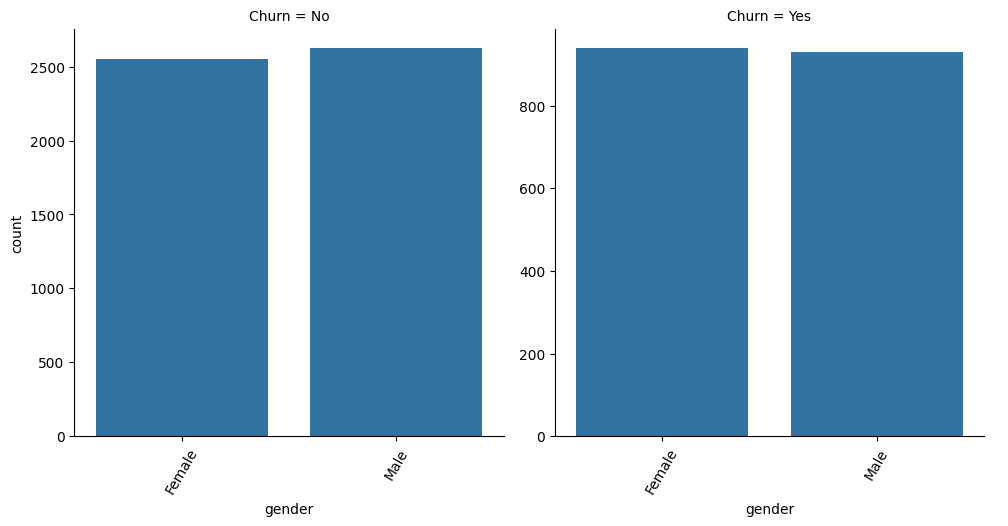

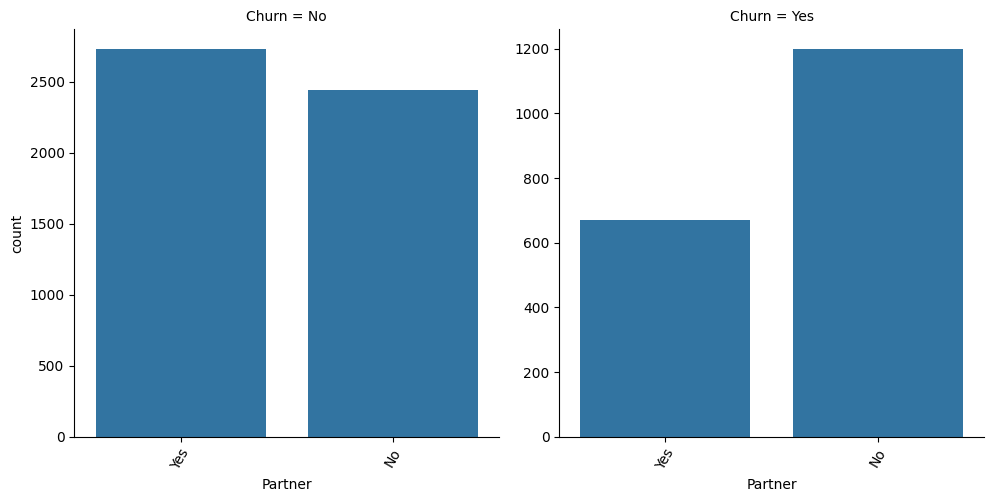

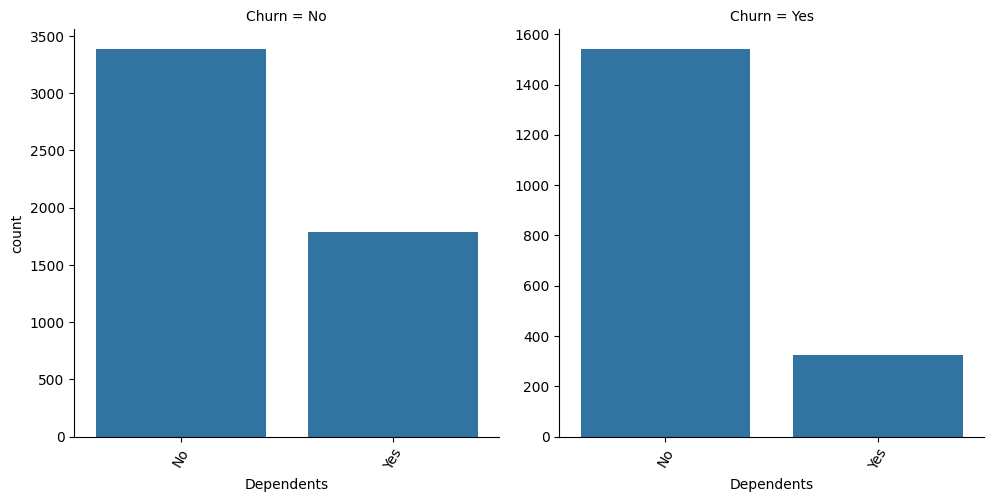

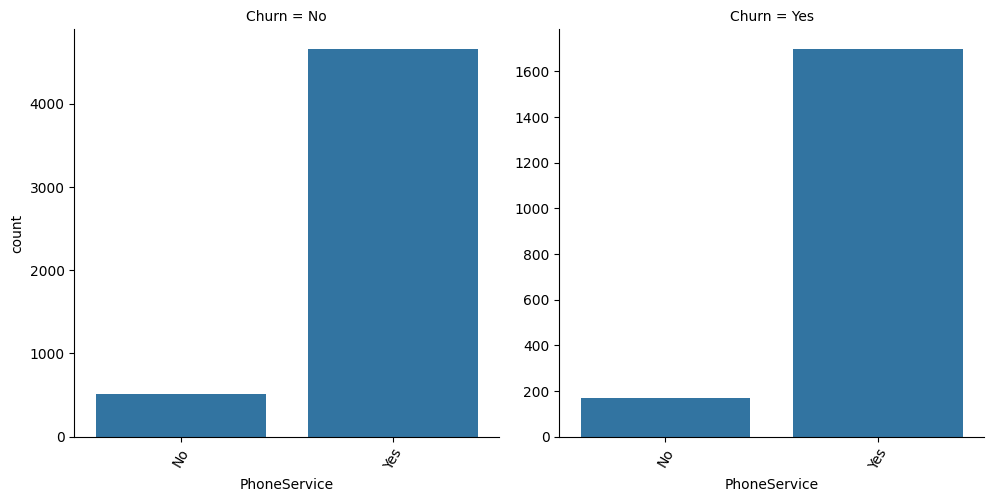

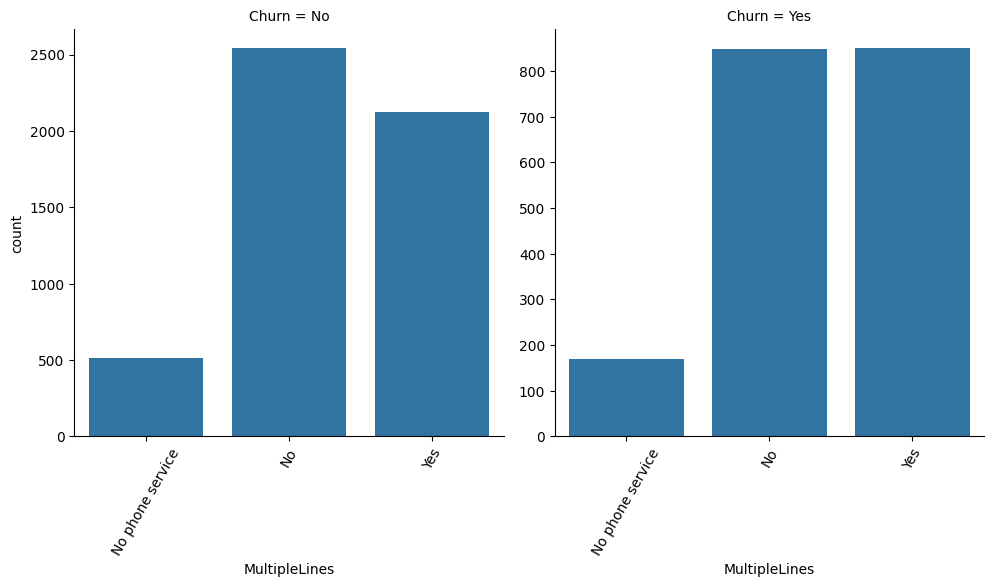

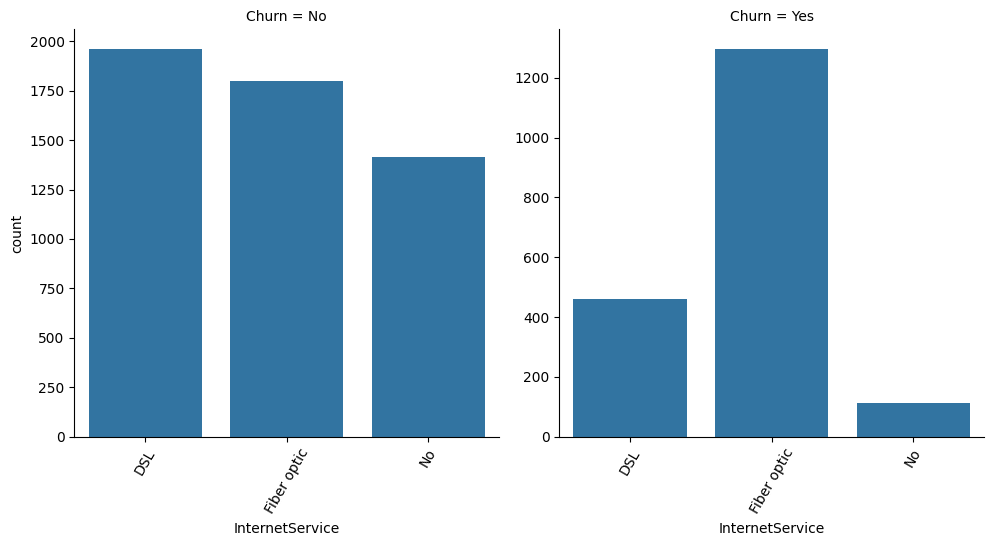

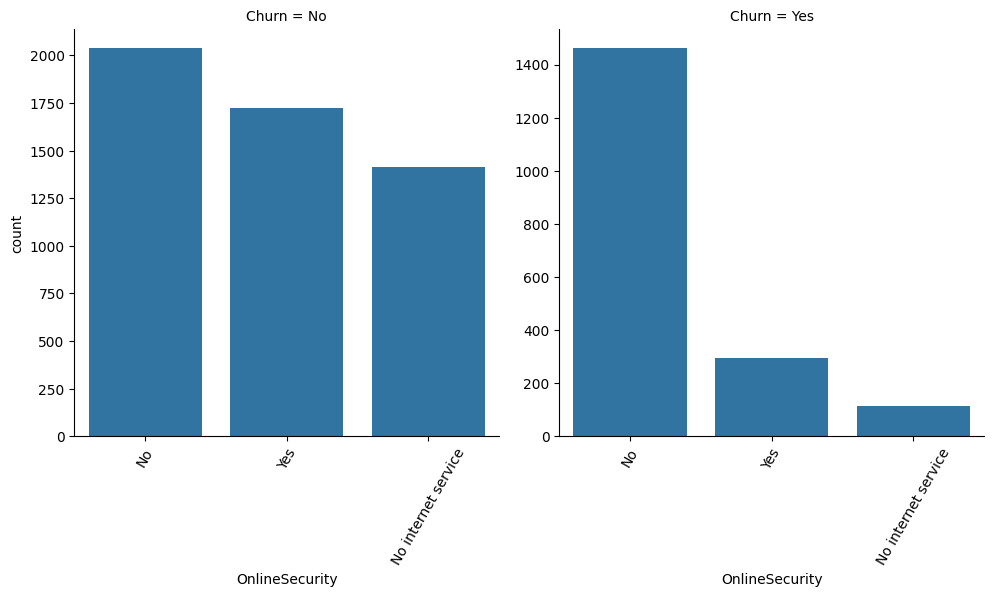

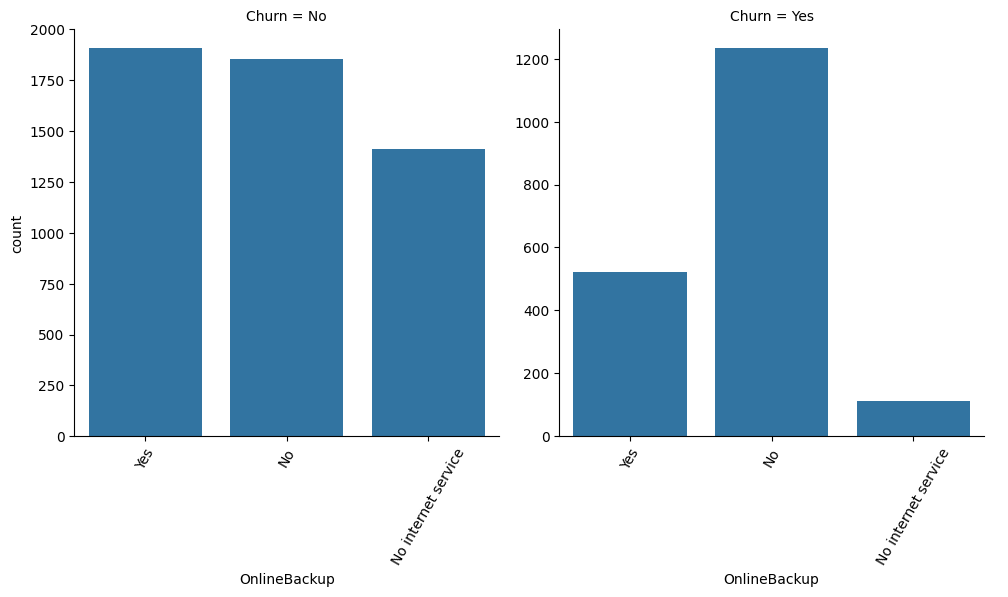

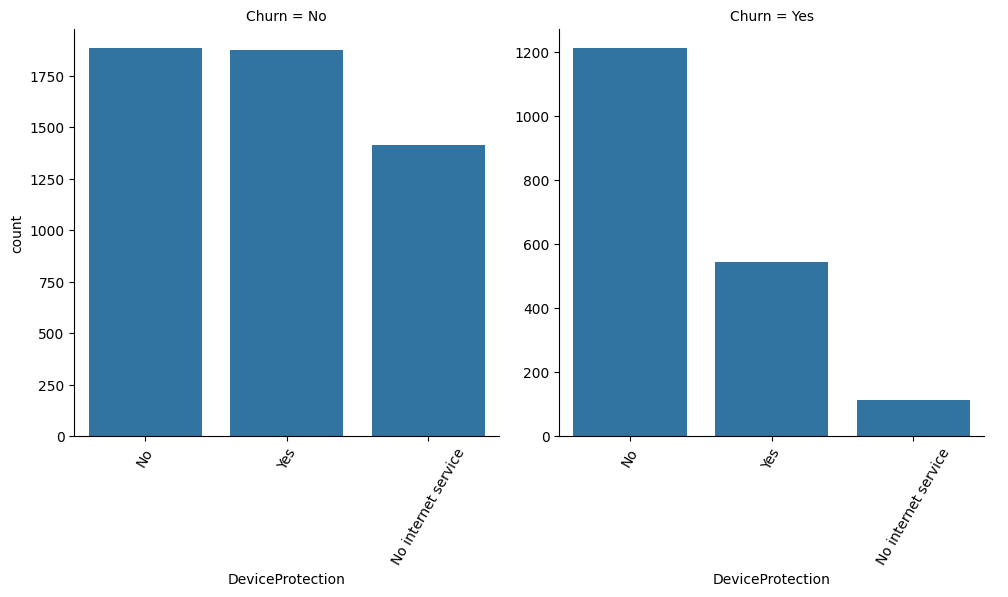

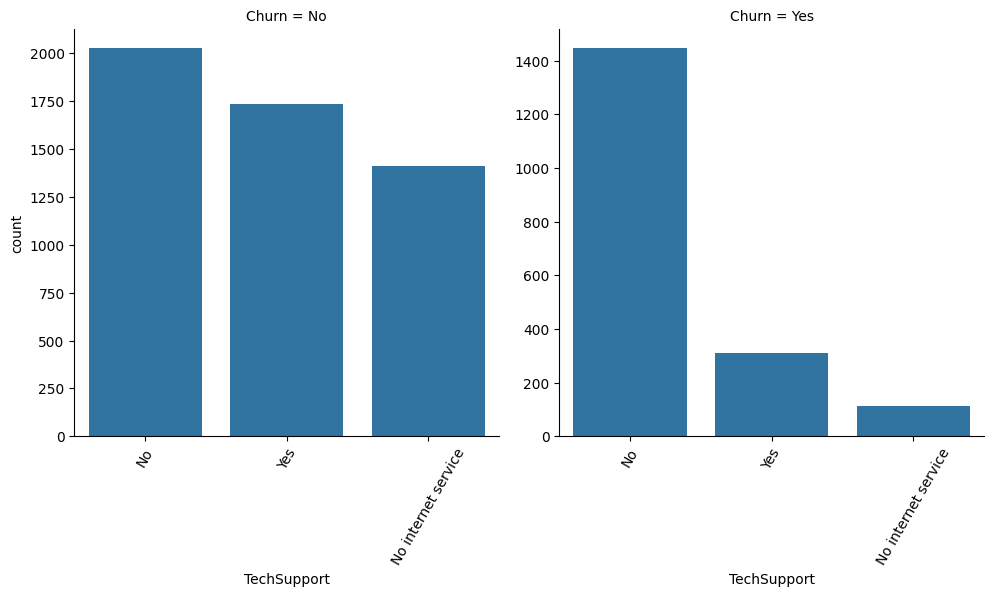

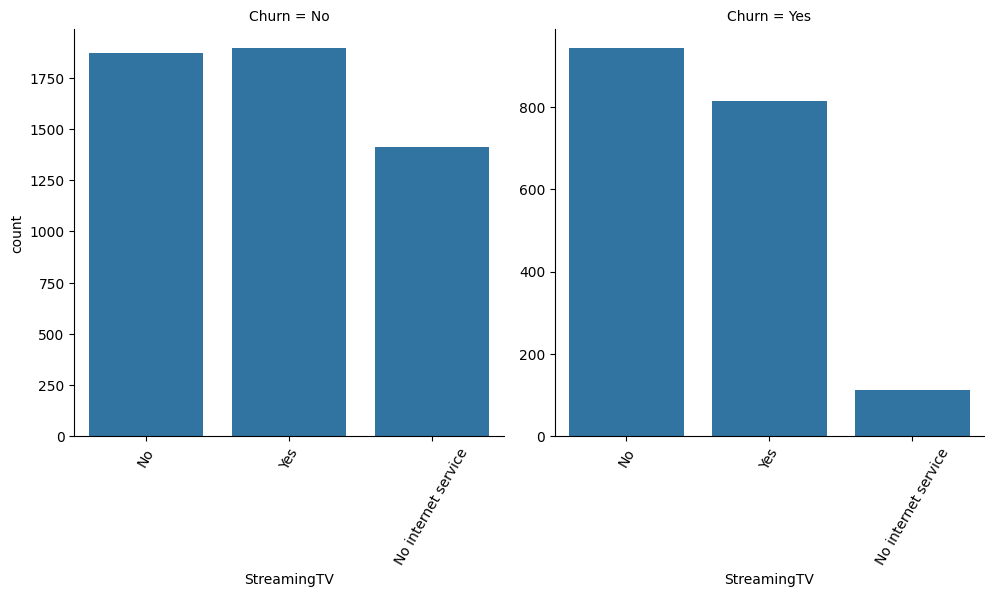

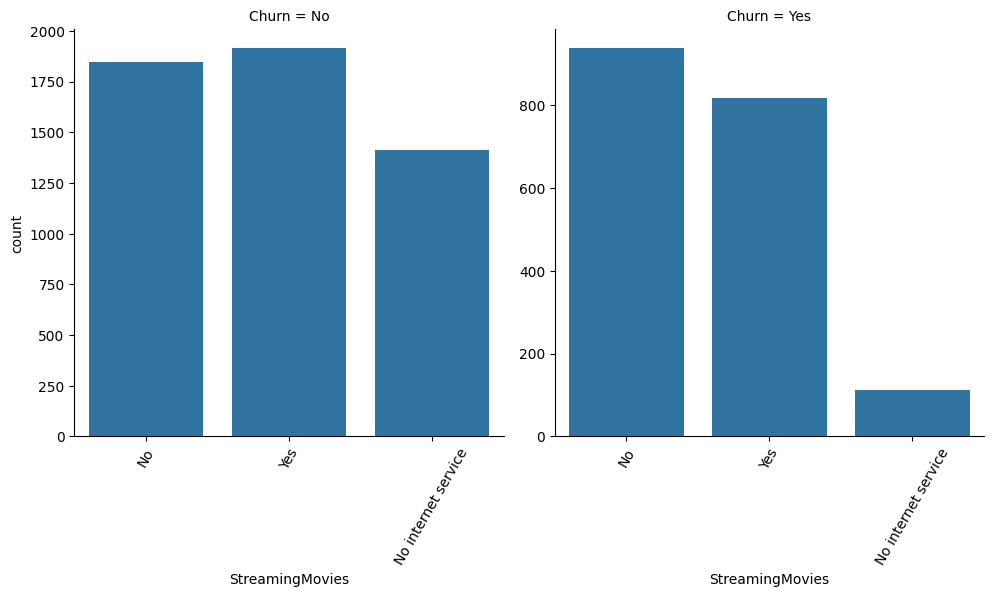

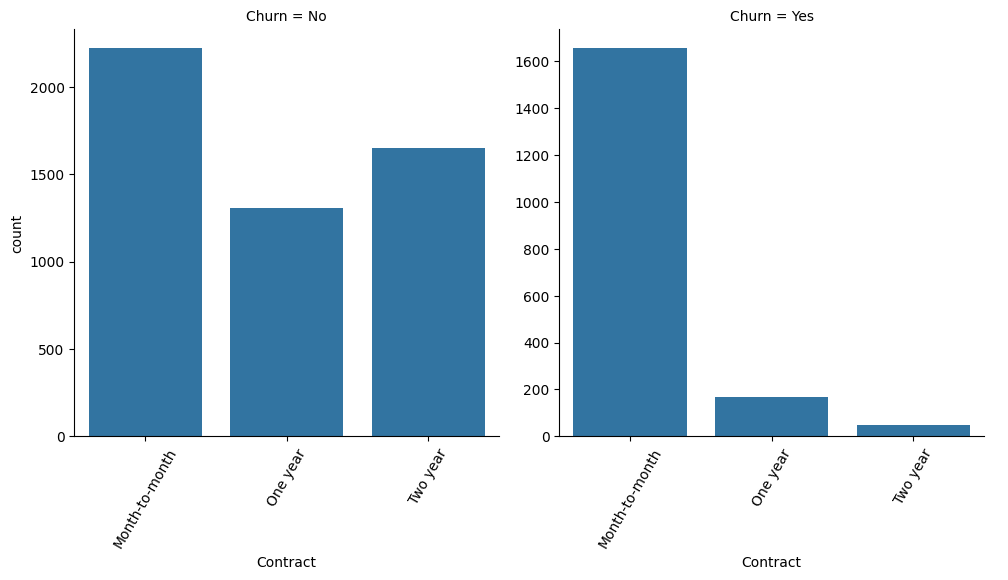

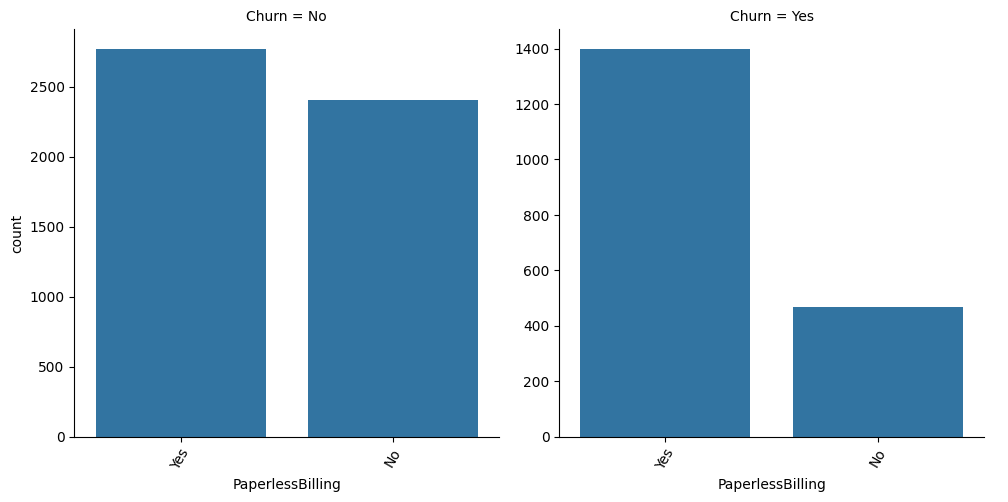

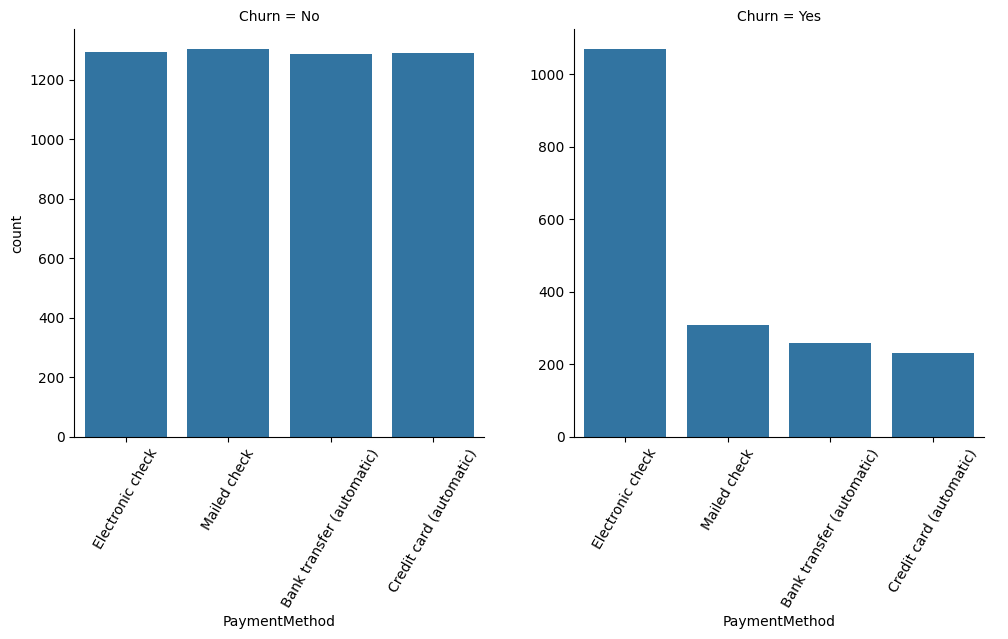

In [337]:
for col in cat_cols:
    g = sns.catplot(x=col, kind='count', col=y, data=df, sharey=False)
    g.set_xticklabels(rotation=60)

На этих графиках мы видим что признаки фичи **gender(пол)** примерно одинаковы на обоих графиках, соответственно не несут в себе значимой информации. Мы дропаем фичу **gender**

In [338]:
X = X.drop(['gender'], axis=1)
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object']).columns

### Препроцессинг - Pipeline

In [339]:
num_cols = X.select_dtypes(include = 'number').columns
cat_cols = X.select_dtypes(include = 'object').columns.to_list()

numeric_pipline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

category_pipline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipline, num_cols),
    ('cat', category_pipline, cat_cols),
])

### Train/Test Split

In [340]:
X_train, X_test, y_train,  y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

### Baseline Model - LogisticRegression

In [341]:
log_reg = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

In [342]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__solver': ['saga'],
    'classifier__l1_ratio': [0, 0.5, 1]
}

grid_lr = GridSearchCV(
    estimator = log_reg,
    param_grid = param_grid,
    cv = 5,
    scoring="roc_auc",
    n_jobs=1
)

grid_lr.fit(X_train, y_train)

y_pred = grid_lr.predict(X_test)
y_proba = grid_lr.predict_proba(X_test)[:, 1]

print("Best params: ", grid_lr.best_params_)
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Best params:  {'classifier__C': 100, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
ROC AUC: 0.8375003229223179
              precision    recall  f1-score   support

          No       0.90      0.73      0.81      1035
         Yes       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



### Продвинутая модель - CatBoost

In [343]:

pipeline_cb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", CatBoostClassifier(
        iterations=500,
        depth = 6,
        learning_rate= 0.05,
        eval_metric='AUC',
        auto_class_weights = 'Balanced',
        verbose=False
    ))
])


param_grid = {
    'classifier__iterations': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [4, 6, 8],
    'classifier__l2_leaf_reg': [1, 3, 5, 10],
    'classifier__bagging_temperature': [0, 1, 5]
}

grid_cb = GridSearchCV(
    estimator = pipeline_cb,
    param_grid = param_grid,
    cv = 5,
    scoring="roc_auc",
    n_jobs=1
)

grid_cb.fit(X_train, y_train)

y_pred = grid_cb.predict(X_test)
y_proba = grid_cb.predict_proba(X_test)[:, 1]


print("Best params: ", grid_cb.best_params_)
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

Best params:  {'classifier__bagging_temperature': 0, 'classifier__depth': 4, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 10, 'classifier__learning_rate': 0.1}
ROC AUC: 0.8443669430881707
              precision    recall  f1-score   support

          No       0.91      0.72      0.80      1035
         Yes       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



### Confusion Matrix

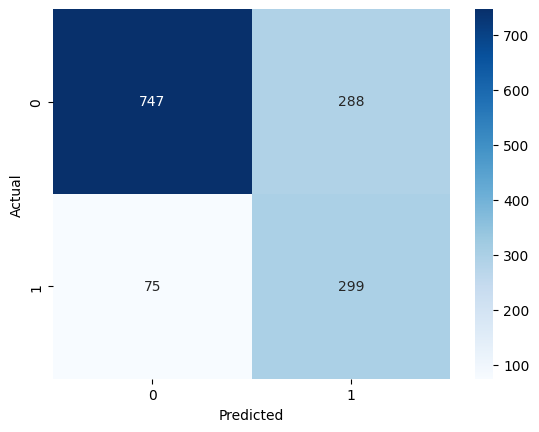

In [312]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Модель достаточно сильная: Сильный ROC AUC, хороший Recall (приоритетная метрика на данной задаче) и средний Precision

ROC AUC =  0.84.4 (сильная модель)
Recall = 0.80 (хорошо)
Precision = 0.51 (средне)

